In [1]:
from collections import deque

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

/Users/leafy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(18263.0, 19797.0)

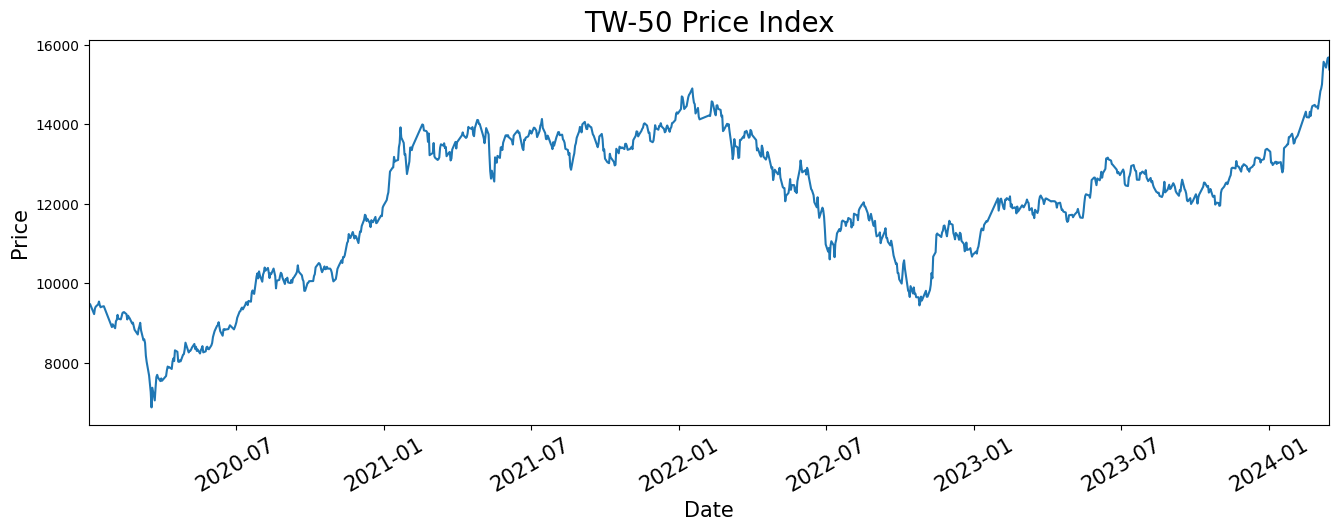

In [2]:
# ===== Data loading and plotting =====

dataset = pd.read_csv('dataset/taiwan50.csv')

# Since we will be predicting the price index, we will be making a dataframe with the values we'd like to predict
# I am lazy, so we just drop the unused columns instead
df = dataset.drop(columns=['Total Return Index', 'Change', '%Change'])
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True)

# Now, we just need to plot the dataset
fig = plt.subplots(figsize=(16, 5))
plt.plot(df['Date'], df['Price Index'])
plt.title('TW-50 Price Index', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2024-03-15'))

In [3]:
N_STEPS = 5
LOOKUP_STEPS = [1, 2, 3, 4, 5]
scaler = MinMaxScaler()

In [4]:
def prepare_data(_df: pd.DataFrame, days):
    ndf = _df.copy()
    ndf['Price Index'] = scaler.fit_transform(np.expand_dims(ndf['Price Index'].values, axis=1))

    ndf['Future'] = ndf['Price Index'].shift(-days)
    last_sequence = np.array(ndf[['Price Index']].tail(days))
    ndf.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(ndf[['Price Index'] + ['Date']].values, ndf['Future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['Price Index'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    x, y = [], []
    for seq, target in sequence_data:
        x.append(seq)
        y.append(target)

    # convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return ndf, last_sequence, x, y

In [5]:
def get_trained_model(x_train, y_train):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60, return_sequences=False),
        tf.keras.layers.Dense(20),
        tf.keras.layers.Dense(1),
    ])

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

In [6]:
# GET PREDICTIONS
predictions = []
x_train, y_train, model = None, None, None

tf.keras.backend.clear_session()
for step in LOOKUP_STEPS:
    _df, last_sequence, x_train, y_train = prepare_data(df, step)
    x_train = x_train[:, :, :len(['Price Index'])].astype(np.float32)

    model = get_trained_model(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/80
127/127 [==============================] - 1s 2ms/step - loss: 0.0209
Epoch 2/80
127/127 [==============================] - 0s 2ms/step - loss: 8.9588e-04
Epoch 3/80
127/127 [==============================] - 0s 2ms/step - loss: 9.3350e-04
Epoch 4/80
127/127 [==============================] - 0s 2ms/step - loss: 8.8582e-04
Epoch 5/80
127/127 [==============================] - 0s 2ms/step - loss: 9.0374e-04
Epoch 6/80
127/127 [==============================] - 0s 2ms/step - loss: 9.4941e-04
Epoch 7/80
127/127 [==============================] - 0s 2ms/step - loss: 9.6646e-04
Epoch 8/80
127/127 [==============================] - 0s 2ms/step - loss: 9.0821e-04
Epoch 9/80
127/127 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 10/80
127/127 [==============================] - 0s 2ms/step - loss: 9.5569e-04
Epoch 11/80
127/127 [==============================] - 0s 2ms/step - loss: 9.8071e-04
Epoch 12/80
127/127 [==============================] - 0s 2ms/step - lo

In [7]:
print(predictions)

[15293.66, 15162.08, 15264.86, 15376.51, 15424.84]


In [8]:
# Execute model for the whole history range
predict_df = df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
predict_df[f'Predicted Index'] = y_predicted_transformed

32/32 [==============================] - 0s 1ms/step


In [9]:
import datetime as dt

# Add predicted results to the table
date_now = dt.date(year=2024, month=3, day=15+2)
date = [date_now + dt.timedelta(days=i) for i in range(0, N_STEPS)] 


for i, d in enumerate(date):
    predict_df.loc[len(predict_df)] = [pd.to_datetime(date[i]), predictions[i], 0]

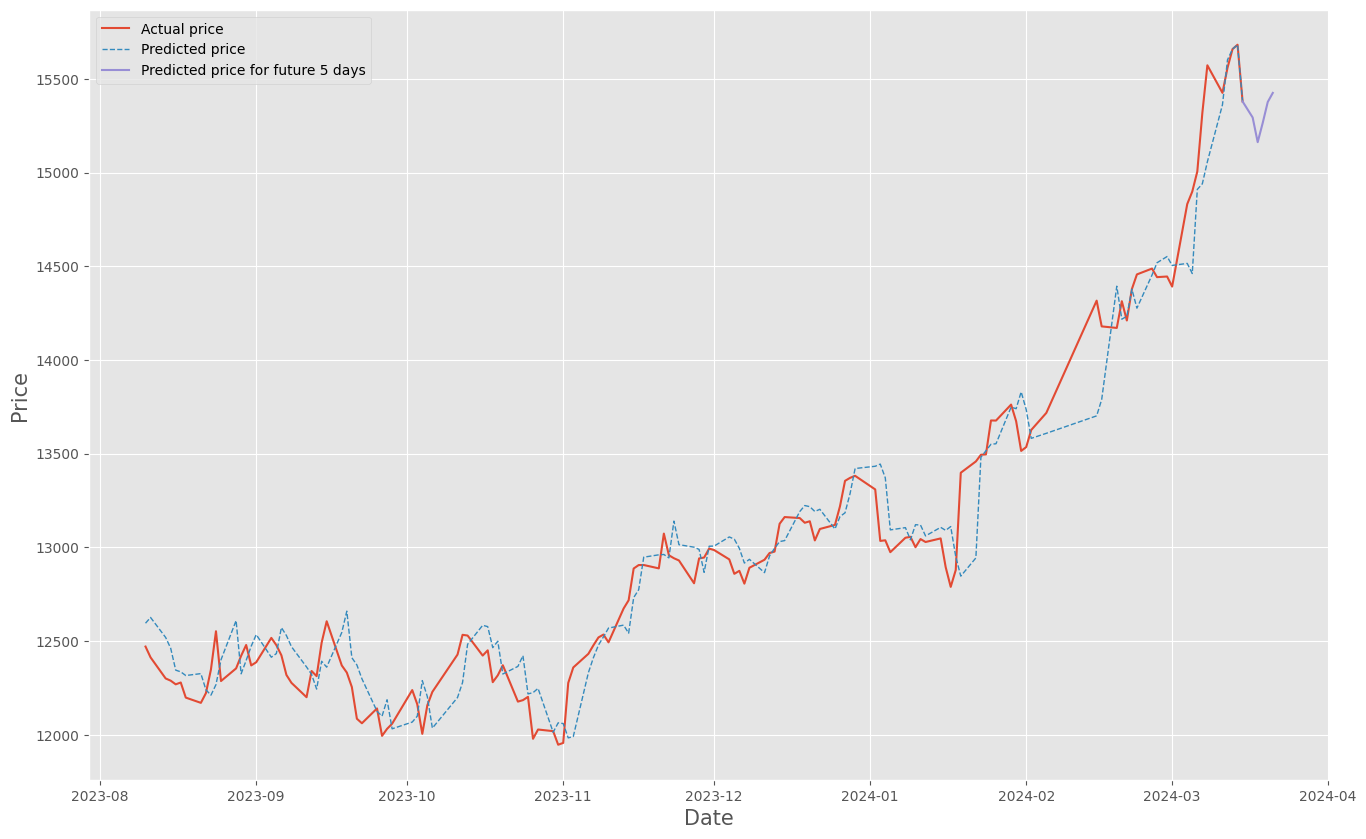

In [10]:
x = predict_df['Date'][-150:]
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(x.head(145), predict_df['Price Index'][-150:].head(145))
plt.plot(x.head(145), predict_df['Predicted Index'][-150:].head(145), linewidth=1, linestyle='dashed')
plt.plot(x.tail(6), predict_df['Price Index'][-150:].tail(6))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend([f'Actual price',
            f'Predicted price',
            f'Predicted price for future 5 days'])
plt.show()

In [11]:
predict_df

,Date,Price Index,Predicted Index
1019,2020-01-02,9450.90,9446.84
1018,2020-01-03,9475.62,9395.56
1017,2020-01-06,9324.26,9408.38
1016,2020-01-07,9272.36,9422.28
1015,2020-01-08,9223.99,8897.67
...,...,...,...
1020,2024-03-17,15293.66,0.00
1021,2024-03-18,15162.08,0.00
1022,2024-03-19,15264.86,0.00
1023,2024-03-20,15376.51,0.00
